# This notebook checks the data from the sqlite database
The checking code checks for the following data
1. Missing data
2. Discrepancy in translated data (ie images with quilt should share the same annotation with cases that have quilt)
3. Extreme data (Image distance > 3 sigma)


The data are currently manually edited using librayr `dataset.gui.fix_images.fix_image.py`
`fix_image.py` should also be updated in later stage. 


One of the problem is, no matter how many iterations, there always 


In [1]:
# Basic definitons and imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
num_joints = 18
database_string = "sqlite:///D:\\Posture Coordinate Models\\dataset.db"
all_data = pd.read_sql_query("SELECT * FROM annotations", database_string)

### Captures 
1. [ ] Every posture have 4 quilt conditions
2. [ ] Every quilt condition have 7 posture
3. [ ] Every subjects have 7 posture
4. [ ] total 150 subjects
5. [ ] 96 training subjects
6. [ ] 24 validation subject
7. [ ] 30 testing subjects

In [2]:
# take a look at the data
all_data.head(5)

,level_0,subject_number,index,image_id,annotation_file,source_file,posture,0_x,0_y,1_x,...,8_confidence,9_confidence,10_confidence,11_confidence,12_confidence,13_confidence,14_confidence,15_confidence,16_confidence,17_confidence
0,0,82,1,4,process\20211112_105525.ass,subject\20211112_105525.bag,r,107.089,82.0153,105.410,...,0.686386,0.781454,0.708149,0.725464,0.771406,0.753817,0.861369,0.884187,0.841067,0.814619
1,1,82,2,4,process\20211112_105525.ass,subject\20211112_105525.bag,r,107.089,82.0153,105.410,...,0.686386,0.781454,0.708149,0.725464,0.771406,0.753817,0.861369,0.884187,0.841067,0.814619
2,2,82,3,4,process\20211112_105525.ass,subject\20211112_105525.bag,r,107.089,82.0153,105.410,...,0.686386,0.781454,0.708149,0.725464,0.771406,0.753817,0.861369,0.884187,0.841067,0.814619
3,3,82,4,4,process\20211112_105525.ass,subject\20211112_105525.bag,r,107.089,82.0153,105.410,...,0.686386,0.781454,0.708149,0.725464,0.771406,0.753817,0.861369,0.884187,0.841067,0.814619
4,8,120,9,12,process\20220108_115516.ass,subject\20220108_115516.bag,r,101.490,69.8623,103.056,...,0.686756,0.705862,0.507983,0.602001,0.745243,0.694008,0.921060,0.866536,0.737365,0.857977


In [3]:
# We don't look at all the joints for basic capture test
basic_capture = all_data[["subject_number", "posture", "effect", "image_id","subset"]]

In [4]:
# 01. Every posture have 4 distinct quilt
rows_to_look = ["subject_number", "posture", "effect"]
counts = basic_capture[rows_to_look].groupby(["subject_number", "posture"]).effect.nunique()
assert (counts == 4).all().all() 


In [5]:
# 01. Every quilt have 7 distinct quilt
rows_to_look = ["subject_number", "posture"]
counts = basic_capture[rows_to_look].groupby(["subject_number"]).posture.nunique()
assert (counts == 7).all().all() 


In [6]:

# 04. Total 150 subjects

counts = basic_capture.groupby(["posture", "effect"]).count()
assert (counts == 150).all().all() , "Total numebr of subjects is not 150"
#counts 

In [7]:
# 05. 96 training subjects
counts = basic_capture[basic_capture["subset"] == "train" ].groupby(["posture", "effect"]).count()
assert (counts == 96).all().all() , "Total numebr of subjects is not 150"
#counts 

In [8]:
# 06. 24 valjidation subjects
counts = basic_capture[basic_capture["subset"] == "val" ].groupby(["posture", "effect"]).count()
assert (counts == 24).all().all() , "Total numebr of subjects is not 150"
#counts 

In [9]:
# 07. 30 testing subjects
counts = basic_capture[basic_capture["subset"] == "test" ].groupby(["posture", "effect"]).count()
assert (counts == 30).all().all()

### Joint Annotations
1. [ ] Every (subject*posture) should have same annotaiton
2. [ ] Every joints are annotated
3. [ ] For each bone, plot a 2d distribution for distance 
4. [ ] For each bone, joints with extreme distance are checked (> sigma)

In [10]:
# check every joints are annotated
all_coordinates_headers = sum([[f"{i}_x", f"{i}_y"] for i in range(num_joints)],start=[])
coordinates = all_data[all_coordinates_headers]
assert (coordinates != 0).all().all() , "Some joints are not annotated"
assert not (coordinates.isnull()).any().any(), "Some joints are not annotated"

In [11]:
#every (subject*posture) should bave the same annotation
grouped = all_data[["subject_number","posture"]+all_coordinates_headers].groupby(["subject_number", "posture"])
same = grouped.agg(lambda x: x.nunique())
assert same.all().all() 

In [12]:
grouped

## 03. Data distributions
For each joint, the posture is ploted with xxx and xx. 

In [13]:
skeleton = [
    [1, 2],
    [2, 3],
    [3, 4],
    [1, 5],
    [5, 6],
    [6, 7],
    [1, 8],
    [8, 9],
    [9, 10],
    [1, 11],
    [11, 12],
    [12, 13],
    [1, 0],
    [0, 14],
    [14, 16],
    [0, 15],
    [15, 17],
]
def draw_skeleton(ax, coordinates, skeleton):
    for joint1, joint2 in skeleton:
        x1, y1 = coordinates[joint1]
        x2, y2 = coordinates[joint2]
        ax.plot([x1, x2], [y1, y2], color="black")

In [14]:
num_joints

18

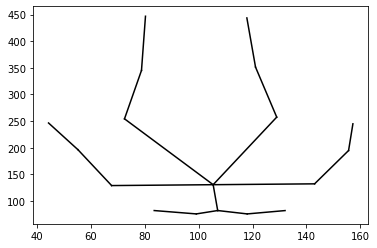

In [15]:
df = all_data
coordinate_array = np.zeros((len(df), num_joints, 2))
for subject, (index, row) in enumerate(df.iterrows()):
    for joint in range(num_joints):
        x, y = float(row[f"{joint}_x"]), float(row[f"{joint}_y"])
        coordinate_array[subject, joint, :] = [x, y]
    draw_skeleton(plt, coordinate_array[subject], skeleton)
    break

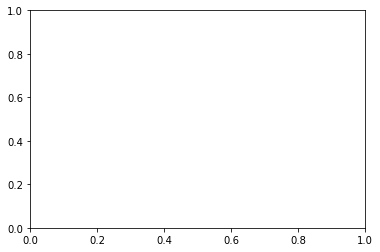

In [16]:
#draw skeleton


fig, ax = plt.subplots()


In [17]:
error_set = set()
    # display_dict = {}
    # for i in skeleton:
    #     x, y = i
    #     # x, y = x - 1, y - 1
    #     distance = np.linalg.norm(array[:, x, :] - array[:, y, :], axis=1) / norm_dist
    #     display_dict[tuple(i)] = distance
    #     # sns.distplot(distance)
    #     # plt.show()
    #     # subjects > 3 sigma
    #     more_than = np.where(distance > distance.mean() + 3 * distance.std())
    #     less_than = np.where(distance < distance.mean() - 3 * distance.std())
    #     # print(f"{i} More than 3 sigma: {more_than}, {distance[more_than]}")
    #     # print(f"{i} Less than 3 sigma: {less_than}, {distance[less_than]}")

    #     subjects_more_than = set(df["image_id"].iloc[more_than])
    #     if any(subjects_more_than):
    #         print(i, subjects_more_than, distance[more_than])
    #     # print(i, subjects_more_than, distance[more_than])
    #     subjects_less_than = set(df["image_id"].iloc[less_than])
    #     if any(subjects_less_than):
    #         print(i, subjects_less_than, distance[less_than])
    #     # print(i, subjects_less_than, distance[less_than])
    #     error_set = error_set.union(subjects_more_than)
    #     error_set = error_set.union(subjects_less_than)

    # print(f"total error of {postures}", list(error_set))